In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
import os

In [3]:
df = pd.read_csv(r"C:\Users\82103\Downloads\필터된 데이터.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 461 entries, 기준년월 to Life_Stage
dtypes: float64(52), int64(381), object(28)
memory usage: 211.0+ MB


In [10]:
df.columns

Index(['기준년월', '발급회원번호', '컨택건수_카드론_TM_B0M', '컨택건수_리볼빙_TM_B0M',
       '컨택건수_CA_TM_B0M', '컨택건수_이용유도_TM_B0M', '컨택건수_신용발급_TM_B0M',
       '컨택건수_부대서비스_TM_B0M', '컨택건수_포인트소진_TM_B0M', '컨택건수_보험_TM_B0M',
       ...
       '유효카드수_신용', '유효카드수_체크', '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_체크',
       '이용카드수_신용체크', '이용카드수_신용', '이용카드수_체크', '이용금액_R3M_신용체크', 'Life_Stage'],
      dtype='object', length=461)

In [9]:
df['잔액_할부_B1M']

0          64096
1         277909
2              0
3              0
4              0
          ...   
59995          0
59996          0
59997    2282921
59998          0
59999          0
Name: 잔액_할부_B1M, Length: 60000, dtype: int64

In [ ]:
from scipy.stats import linregress

In [ ]:
# -------------------------------------------------------
# 2. 6개월치 기울기(Slope) 계산 함수
# -------------------------------------------------------
def calc_slope_6m(series):
    # 데이터가 6개월치가 안 되면 (중도 가입 등) 처리
    if len(series) < 2: 
        return 0
    
    y = series.values
    x = np.arange(len(y))  # [0, 1, 2, 3, 4, 5] (시간 축)
    
    # 모두 0이면 기울기 0
    if np.sum(y) == 0: 
        return 0
        
    slope, _, _, _, _ = linregress(x, y)
    
    # (선택) 정규화: 잔액 규모 차이를 보정하고 싶다면 평균으로 나눔
    # slope = slope / np.mean(y) 
    
    return slope

# -------------------------------------------------------
# 3. 고객별(groupby) 6개월 추세 변수 생성
# -------------------------------------------------------
# (1) 먼저 데이터를 '회원번호'와 '기준년월' 순으로 정렬해야 정확한 시계열이 됩니다.
df = df.sort_values(by=['발급회원번호', '기준년월'])

# (2) 고객별로 묶어서 기울기 계산 적용
# 잔액 기울기 (부채가 줄어드는지, 늘어나는지)
slope_balance = df.groupby('발급회원번호')['잔액_합계_B0M'].apply(calc_slope_6m)

# 이용금액 기울기 (소비가 줄어드는지)
slope_spend = df.groupby('발급회원번호')['이용금액_신용_B0M'].apply(calc_slope_6m)

# 이용건수 기울기 (사용 빈도가 줄어드는지)
slope_count = df.groupby('발급회원번호')['이용건수_신용_B0M'].apply(calc_slope_6m)

# -------------------------------------------------------
# 4. 결과를 하나의 데이터프레임으로 합치기
# -------------------------------------------------------
df_features = pd.DataFrame({
    'Slope_Balance_6M': slope_balance,
    'Slope_Spend_6M': slope_spend,
    'Slope_Count_6M': slope_count
}).reset_index()

print(df_features)

In [44]:
import pandas as pd
import numpy as np

# 2. 결측치 처리 (안전장치)
df['증감율_이용금액_신용_전월'] = df['증감율_이용금액_신용_전월'].fillna(0)
df['연체잔액_B0M'] = df['연체잔액_B0M'].fillna(0)

# 3. 이탈 위험군 조건 정의 (4가지)
cond_status = (df['회원여부_이용가능'] == 0)
cond_inactive = (df['연속무실적개월수_기본_24M_카드'] >= 2)
cond_drop = (df['증감율_이용금액_신용_전월'] <= -0.3)
cond_overdue = (df['연체잔액_B0M'] > 0)

# 4. [핵심] 옆에 피쳐 하나 만들기! (Churn_Refined)
df['Churn_Refined'] = np.where(cond_status | cond_inactive | cond_drop | cond_overdue, 1, 0)

# 5. 결과 확인 (눈으로 직접 보기)
print("새로 생긴 컬럼 확인:")
print(df[['발급회원번호', 'Churn_Refined']].head()) # 회원번호 옆에 딱 붙었는지 확인!

새로 생긴 컬럼 확인:
  발급회원번호  Churn_Refined
0  SYN_0              0
1  SYN_1              1
2  SYN_2              1
3  SYN_3              0
4  SYN_4              1


In [45]:
df_general = df[df['VIP등급코드'] == '_']

# VIP 고객: 코드가 '_' 가 아닌 경우 (숫자가 있는 경우)
df_vip = df[df['VIP등급코드'] != '_']

# --- 결과 확인 ---
print(f"전체 데이터: {len(df)}건")
print(f"VIP 고객: {len(df_vip)}건")
print(f"일반 고객: {len(df_general)}건")

전체 데이터: 60000건
VIP 고객: 11460건
일반 고객: 48540건


In [46]:
df_vip.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11460 entries, 0 to 59999
Columns: 462 entries, 기준년월 to Churn_Refined
dtypes: float64(52), int64(382), object(28)
memory usage: 40.5+ MB


In [ ]:
# !pip install shap xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 3.3 MB/s eta 0:00:22
   --- ------------------------------------ 5.8/72.0 MB 14.7 MB/s eta 0:00:05
   ------- -------------------------------- 13.6/72.0 MB 22.5 MB/s eta 0:00:03
   ------------- -------------------------- 24.1/72.0 MB 29.3 MB/s eta 0:00:02
   ------------------ --------------------- 33.0/72.0 MB 32.3 MB/s eta 0:00:02
   ------------------------ --------------- 43.3/72.0 MB 34.8 MB/s eta 0:00:01
   ----------------------------- ---------- 52.7/72.0 MB 36.1 MB/s eta 0:00:01
   ---------------------------------- ----- 61.3/72.0 MB 36.5 MB/s eta 0:00:01
   -------------------------------------- - 69.5/72.0 MB 36.9 MB/s eta 0:00:01
   ---------------------------------------  71.8/72.0 MB 34.4 MB/s eta 0:00:01
   ---------------------------------------  71.8/72.0 MB 34.4 MB/s eta 0:

In [47]:
df_vip.columns

Index(['기준년월', '발급회원번호', '컨택건수_카드론_TM_B0M', '컨택건수_리볼빙_TM_B0M',
       '컨택건수_CA_TM_B0M', '컨택건수_이용유도_TM_B0M', '컨택건수_신용발급_TM_B0M',
       '컨택건수_부대서비스_TM_B0M', '컨택건수_포인트소진_TM_B0M', '컨택건수_보험_TM_B0M',
       ...
       '유효카드수_체크', '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_체크', '이용카드수_신용체크',
       '이용카드수_신용', '이용카드수_체크', '이용금액_R3M_신용체크', 'Life_Stage', 'Churn_Refined'],
      dtype='object', length=462)

In [48]:
df_vip.head()

,기준년월,발급회원번호,컨택건수_카드론_TM_B0M,컨택건수_리볼빙_TM_B0M,컨택건수_CA_TM_B0M,컨택건수_이용유도_TM_B0M,컨택건수_신용발급_TM_B0M,컨택건수_부대서비스_TM_B0M,컨택건수_포인트소진_TM_B0M,컨택건수_보험_TM_B0M,...,유효카드수_체크,이용가능카드수_신용체크,이용가능카드수_신용,이용가능카드수_체크,이용카드수_신용체크,이용카드수_신용,이용카드수_체크,이용금액_R3M_신용체크,Life_Stage,Churn_Refined
0,201807,SYN_0,0,0,0,0,0,0,0,0,...,1,2,1,1,1,1,0,19612,5.자녀성장기(2),0
8,201807,SYN_8,0,0,0,0,0,0,0,0,...,0,4,4,0,3,3,0,7464463,1.Single,0
9,201807,SYN_9,0,0,0,0,0,0,0,0,...,0,3,3,0,2,2,0,422575,3.자녀출산기,0
17,201807,SYN_17,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,0,1981124,7.노령,0
18,201807,SYN_18,0,0,0,0,0,0,0,0,...,2,2,0,2,1,0,1,158122,4.자녀성장기(1),1


In [49]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. 학습 데이터(X)와 타겟(y) 준비
# -----------------------------------------------------------------------------
# 타겟 변수
target_col = 'Churn_Refined'

# 제외할 컬럼들: 타겟(정답) + 타겟을 만들 때 쓴 재료들(정답누설 방지) + 식별자(ID)
# (데이터에 '발급회원번호' 같은 ID가 있다면 반드시 제외해야 합니다)
cols_to_drop = [
    'Churn_Refined',                # 정답
    '증감율_이용금액_신용_전월',    # 재료 1
    '연체잔액_B0M',                 # 재료 2
    '회원여부_이용가능',            # 재료 3
    '연속무실적개월수_기본_24M_카드', # 재료 4
    'VIP등급코드',                  # (선택) 모두 VIP이므로 변별력이 없다면 제외
    '발급회원번호'                  # (만약 있다면) ID는 제외
]

# 실제 df_vip에 존재하는 컬럼만 골라서 drop (에러 방지)
existing_drop_cols = [c for c in cols_to_drop if c in df_vip.columns]

X = df_vip.drop(columns=existing_drop_cols)
y = df_vip[target_col]

# -----------------------------------------------------------------------------
# 2. 문자열 데이터 숫자 변환 (인코딩)
# -----------------------------------------------------------------------------
# XGBoost는 숫자만 이해하므로 문자열(Object)을 숫자로 바꿉니다.
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = X[col].astype('category').cat.codes

print(f"분석에 사용되는 피처(X) 개수: {X.shape[1]}개")
print(f"사용 피처 목록: {list(X.columns)}")

# -----------------------------------------------------------------------------
# 3. 모델 학습 (XGBoost Classifier)
# -----------------------------------------------------------------------------
# 분류 모델(0 또는 1 예측) 사용
model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
model.fit(X, y)

# -----------------------------------------------------------------------------
# 4. SHAP 값 계산
# -----------------------------------------------------------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)


분석에 사용되는 피처(X) 개수: 455개
사용 피처 목록: ['기준년월', '컨택건수_카드론_TM_B0M', '컨택건수_리볼빙_TM_B0M', '컨택건수_CA_TM_B0M', '컨택건수_이용유도_TM_B0M', '컨택건수_신용발급_TM_B0M', '컨택건수_부대서비스_TM_B0M', '컨택건수_포인트소진_TM_B0M', '컨택건수_보험_TM_B0M', '컨택건수_카드론_LMS_B0M', '컨택건수_CA_LMS_B0M', '컨택건수_리볼빙_LMS_B0M', '컨택건수_이용유도_LMS_B0M', '컨택건수_카드론_EM_B0M', '컨택건수_CA_EM_B0M', '컨택건수_리볼빙_EM_B0M', '컨택건수_이용유도_EM_B0M', '컨택건수_카드론_청구서_B0M', '컨택건수_CA_청구서_B0M', '컨택건수_리볼빙_청구서_B0M', '컨택건수_이용유도_청구서_B0M', '컨택건수_카드론_인터넷_B0M', '컨택건수_CA_인터넷_B0M', '컨택건수_리볼빙_인터넷_B0M', '컨택건수_이용유도_인터넷_B0M', '컨택건수_카드론_당사앱_B0M', '컨택건수_CA_당사앱_B0M', '컨택건수_리볼빙_당사앱_B0M', '컨택건수_이용유도_당사앱_B0M', '컨택건수_카드론_TM_R6M', '컨택건수_CA_TM_R6M', '컨택건수_리볼빙_TM_R6M', '컨택건수_이용유도_TM_R6M', '컨택건수_신용발급_TM_R6M', '컨택건수_부대서비스_TM_R6M', '컨택건수_포인트소진_TM_R6M', '컨택건수_보험_TM_R6M', '컨택건수_카드론_LMS_R6M', '컨택건수_CA_LMS_R6M', '컨택건수_리볼빙_LMS_R6M', '컨택건수_이용유도_LMS_R6M', '컨택건수_카드론_EM_R6M', '컨택건수_CA_EM_R6M', '컨택건수_리볼빙_EM_R6M', '컨택건수_이용유도_EM_R6M', '컨택건수_카드론_청구서_R6M', '컨택건수_CA_청구서_R6M', '컨택건수_리볼빙_청구서_R6M', '컨택건수_이용유도_청구서_R6M', '컨택건수_카드론_인터넷


[SHAP Summary Plot]


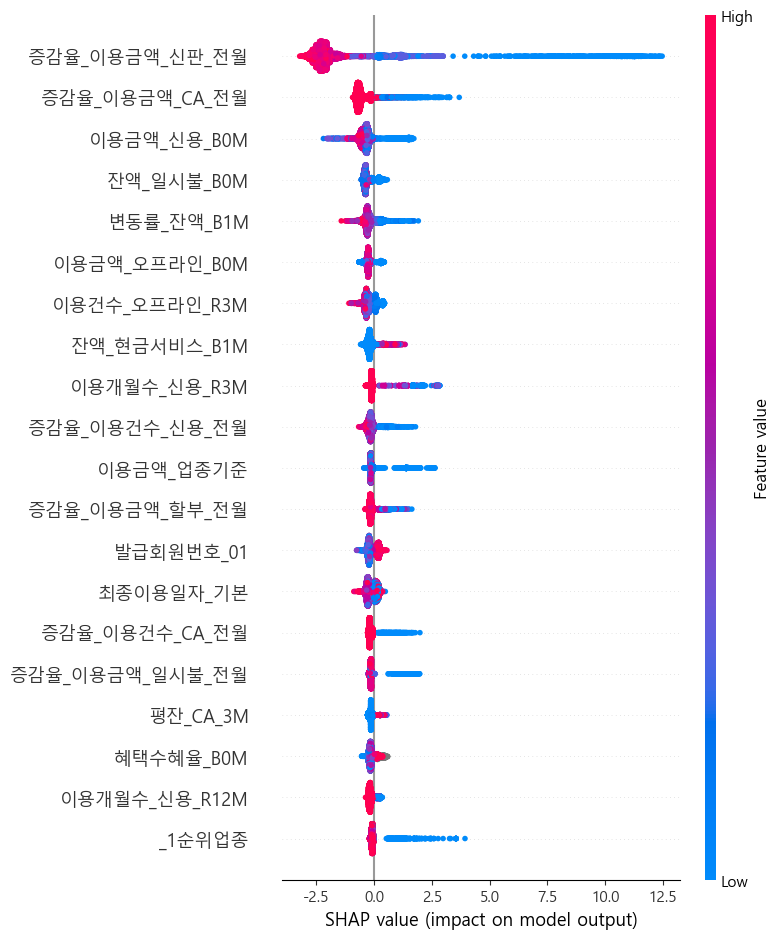


[Feature Importance Bar Plot]


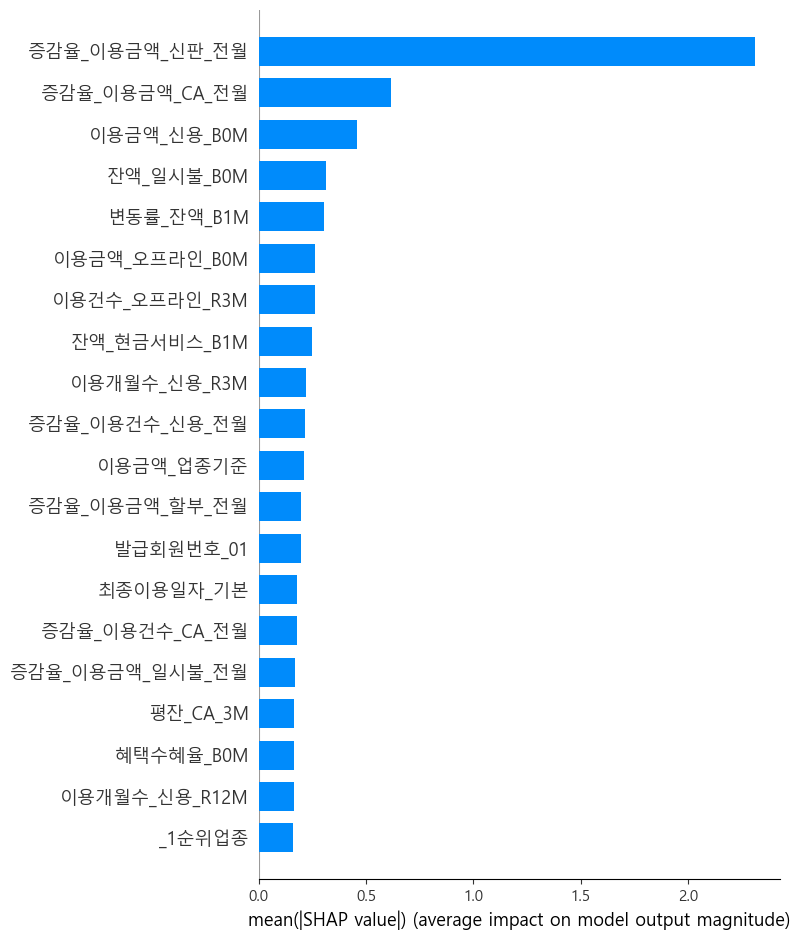

In [50]:

# -----------------------------------------------------------------------------
# 5. 시각화 (인사이트 도출)
# -----------------------------------------------------------------------------
# 한글 폰트 깨짐 방지 (Windows 기준 Malgun Gothic, Mac은 AppleGothic으로 변경 필요)
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# (1) Summary Plot (전체적인 영향력)
print("\n[SHAP Summary Plot]")
plt.figure()
shap.summary_plot(shap_values, X, plot_type="dot") # dot이 기본, bar로 바꾸면 막대그래프

# (2) 중요도 순위 (Bar Plot)
print("\n[Feature Importance Bar Plot]")
plt.figure()
shap.summary_plot(shap_values, X, plot_type="bar")

In [51]:
import pandas as pd
import numpy as np

# -----------------------------------------------------------------------------
# 5. 전체 피처 중요도 추출 및 정렬
# -----------------------------------------------------------------------------
# (1) 각 피처별 SHAP 값의 절대값 평균 계산 (이게 곧 중요도입니다)
# shap_values가 리스트 형태(멀티클래스)인 경우와 배열 형태(이진분류)인 경우를 구분
if isinstance(shap_values, list):
    # 만약 list라면 class 1(이탈)에 대한 값을 가져옵니다.
    vals = np.abs(shap_values[1]).mean(0)
else:
    # 일반적인 경우
    vals = np.abs(shap_values).mean(0)

# (2) 데이터프레임 생성 (피처이름 - 중요도)
feature_importance = pd.DataFrame(list(zip(X.columns, vals)), columns=['col_name', 'feature_importance_vals'])

# (3) 중요도 순으로 정렬 (내림차순)
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

# -----------------------------------------------------------------------------
# 6. 결과 확인 (전체 출력 설정)
# -----------------------------------------------------------------------------
# pandas 출력 옵션 변경: 행(row) 제한을 풀어버림
pd.set_option('display.max_rows', None) 

print(f"전체 피처 개수: {len(feature_importance)}개")
print(feature_importance)

# (선택사항) 다시 원래대로 줄여서 보고 싶을 때를 위해 옵션 원복
# pd.reset_option('display.max_rows')

# -----------------------------------------------------------------------------
# 7. 엑셀이나 CSV로 저장 (추천)
# -----------------------------------------------------------------------------
# 너무 길어서 화면에서 보기 힘들면 파일로 저장해서 보는 게 가장 편합니다.
feature_importance.to_csv("shap_feature_importance_filtered.csv", index=False, encoding='utf-8-sig')
print("전체 결과가 'shap_feature_importance_filtered.csv' 파일로 저장되었습니다.")

전체 피처 개수: 455개
               col_name  feature_importance_vals
72       증감율_이용금액_신판_전월                 2.311119
75       증감율_이용금액_CA_전월                 0.614346
117         이용금액_신용_B0M                 0.458301
333          잔액_일시불_B0M                 0.315510
106          변동률_잔액_B1M                 0.305909
243       이용금액_오프라인_B0M                 0.264278
241       이용건수_오프라인_R3M                 0.262826
349        잔액_현금서비스_B1M                 0.246495
137        이용개월수_신용_R3M                 0.219269
65       증감율_이용건수_신용_전월                 0.213688
138           이용금액_업종기준                 0.209520
74       증감율_이용금액_할부_전월                 0.197214
64            발급회원번호_01                 0.195423
113           최종이용일자_기본                 0.181025
69       증감율_이용건수_CA_전월                 0.180689
73      증감율_이용금액_일시불_전월                 0.170201
399            평잔_CA_3M                 0.166449
110           혜택수혜율_B0M                 0.165562
131       이용개월수_신용_R12M                 0.164946
175  